#                                       Portfolio Optimization & Monte Carlo Simulation

In [182]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import hvplot.pandas
import locale
locale.setlocale( locale.LC_ALL, 'en_CA.UTF-8' )
%matplotlib inline
import yfinance as yf

## Create and Analyse Your Desired Portfolio

#### Enter list of stocks

In [158]:
user_portfolio = []
imput_tickers = input("Enter ticker symbols separated by a comma:") or ("MSFT,AAPL,AMZN,GOOGL,V")
user_portfolio.extend(map(str, imput_tickers.split(",")))
print(user_portfolio)
type(user_portfolio)

Enter ticker symbols separated by a comma: 


['MSFT', 'AAPL', 'AMZN', 'GOOGL', 'V']


list

#### Enter desired weight distribution for selected stocks

In [161]:
p_weights = []
imput_weight = input() or ('0.2,0.2,0.2,0.2,0.2')
p_weights.extend(map(float, imput_weight.split(",")))
print(p_weights)
print(f'Sum of weights=:{sum(p_weights)}')

[0.2, 0.2, 0.2, 0.2, 0.2]
Sum of weights=:1.0


#### Select desired benchmark to simulate results

In [163]:
imput_bm = input("Enter benchmark symbol:") or ("SPY")
benchmark = imput_bm.split(',')
print(benchmark)
type(benchmark)

Enter benchmark symbol: 


['SPY']


list

#### Define number of simulations & number of periods per simulation

In [164]:
number_simulations = 5
number_records =252*8 #252 trading days * no of years

## Import Data

In [165]:
# Datasource Yahoo Finance

list_of_tickers=benchmark+user_portfolio

data = yf.download(
        tickers = list_of_tickers,
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        period = "30y",
        interval = "1d",
        group_by = 'ticker',
        # adjust all OHLC automatically, adjusted for stock splits
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )
data.tail()

[*********************100%***********************]  6 of 6 completed


V                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-05-11  183.562638  184.311384  181.126714  183.253159   8680400.0   
2020-05-12  183.253158  183.682447  179.070159  179.169998   8219700.0   
2020-05-13  178.500000  181.089996  175.039993  177.089996  13377100.0   
2020-05-14  175.940002  181.050003  173.820007  180.899994   9693900.0   
2020-05-15  179.979996  184.139999  178.869995  183.490005  10778662.0   

                   AMZN                                                    \
                   Open         High          Low        Close     Volume   
Date                                                                        
2020-05-11  2374.699951  2419.669922  2372.110107  2409.000000  3253700.0   
2020-05-12  2411.850098  2419.000000  2355.000000  2356.949951  3074900.0   
2020-05-13  2366.800049  2407.699951  2337.800049  2367.919922  4782900.0   
2020-05-14  2361.010010  2391.370117  2353.209961  2388.850098  3640700.0   
2020-05-15  2368.520020  2411.000000  2356.375000  2409.780029  4066463.0   

            ...        MSFT                                                \
            ...        Open        High         Low       Close    Volume   
Date        ...                                                             
2020-05-11  ...  183.149994  187.509995  182.850006  186.740005  30809400   
2020-05-12  ...  186.800003  187.039993  182.300003  182.509995  32038200   
2020-05-13  ...  182.550003  184.050003  176.539993  179.750000  44711500   
2020-05-14  ...  177.539993  180.690002  175.679993  180.529999  41818400   
2020-05-15  ...  179.059998  183.460007  177.000000  183.160004  37376952   

                  AAPL                                                
                  Open        High         Low       Close    Volume  
Date                                                                  
2020-05-11  308.100006  317.049988  307.239990  315.010010  36405900  
2020-05-12  317.829987  319.690002  310.910004  311.410004  40575300  
2020-05-13  312.149994  315.950012  303.209991  307.649994  50155600  
2020-05-14  304.510010  309.790009  301.529999  309.540009  39648100  
2020-05-15  300.350006  307.899994  300.420013  307.709991  40697141  

[5 rows x 30 columns]

## Data cleanup

In [167]:
# Historic adjusted close prices
df_yf = data.sort_index()
df_yf.drop(columns=['Open', 'High', 'Low', 'Volume'], level=1, inplace=True)
df_yf = df_yf.droplevel(axis=1, level=1)
df_yf.index = df_yf.index.date
df_yf.dropna(inplace=True)
df_yf.hvplot(title ="Historic Stocks & Benchmark Performance")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [168]:
# Isolate cleaned data
user_portfolio_df=df_yf.drop([benchmark[0]], axis =1)
bm_portfolio_df=df_yf[benchmark[0]]

# Calculate daily returns
user_portfolio_returns = user_portfolio_df.pct_change().dropna()
bm_portfolio_returns = bm_portfolio_df.pct_change().dropna()

In [181]:
bm_portfolio_returns.hvplot(title ="Benchmark historic returns")

:Curve   [index]   (SPY)

In [180]:
user_portfolio_returns.hvplot(title ="Stocks historic returns")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Define variables for Benchmark Monte Carlo simulation

In [170]:
bm_portfolio_ret_mean = bm_portfolio_returns.mean()
bm_portfolio_ret_std = bm_portfolio_returns.std()
bm_last_price = bm_portfolio_df[-1]

#TODO provide clear message to user, round to two decimal points
#we might want to illustrate what standard deviation means
print(f'Your portfolio average historical returns for the BM is:{bm_portfolio_ret_mean}')
print(f'Your portfolio standard deviation for the BM is:{bm_portfolio_ret_std}')
print(f'The present value of your benchmark is:{bm_last_price}')

Your portfolio average historical returns for the BM is:0.00042723164445259353
Your portfolio standard deviation for the BM is:0.013228802500195777
The present value of your benchmark is:286.2799987792969


## Run BM Monte Carlo Simulation

In [171]:
# Global variables being used
# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
bm_montecarlo_returns = pd.DataFrame()

# Run the simulation of projecting stock prices
for n in range(number_simulations):
    simulated_benchmark_prices = [bm_last_price]
    for i in range(number_records):
        simulated_benchmark_price = simulated_benchmark_prices[-1] * (1 + np.random.normal(bm_portfolio_ret_mean, bm_portfolio_ret_std))
        simulated_benchmark_prices.append(simulated_benchmark_price)
    simulated_price_df["SPY prices"] = pd.Series(simulated_benchmark_prices)
    simulated_daily_returns_bm = simulated_price_df.pct_change()
    b_weights = [1.00] 
    portfolio_daily_returns = simulated_daily_returns_bm.dot(b_weights)
    bm_montecarlo_returns[f'T{n}'] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
bm_montecarlo_returns

,T0,T1,T2,T3,T4
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989636,1.010523,1.010059,0.991068,1.025125
2,0.986797,1.010212,1.020154,0.999250,1.018753
3,0.973093,1.013866,1.020203,0.990245,1.015199
4,0.984940,1.017271,1.029292,1.010568,1.024335
...,...,...,...,...,...
2012,2.308465,3.142530,5.080248,0.720919,2.195841
2013,2.288278,3.208754,4.978402,0.726881,2.227694
2014,2.258037,3.189634,5.007274,0.711076,2.252609
2015,2.245160,3.231490,4.993968,0.706544,2.252279


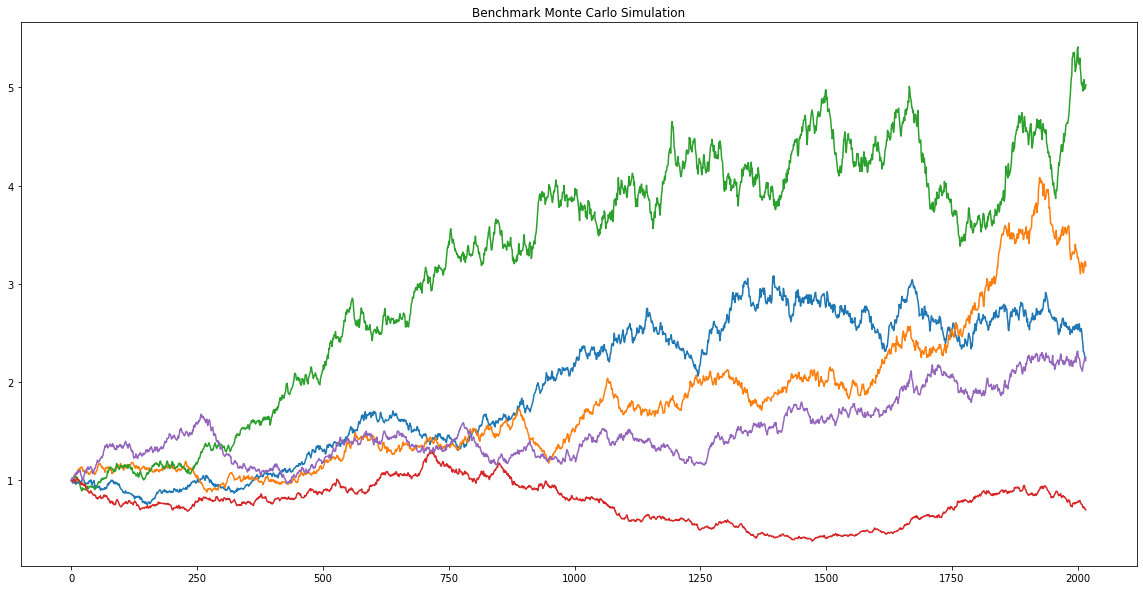

In [172]:
bm_montecarlo_returns.plot(title="Benchmark Monte Carlo Simulation",legend=None, figsize=(20,10))

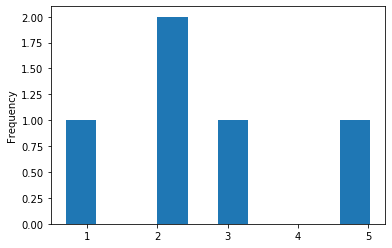

In [184]:
bm_cumulative_ret=bm_montecarlo_returns.iloc[-1, :]
bm_cumulative_ret.plot(kind='hist', bins=10)

## Define variables for portfolio Monte Carlo simulation

In [175]:
pf_means = {}
pf_std = {}
pf_last_day = {}

for stock in user_portfolio:
    pf_means[stock] = user_portfolio_returns.mean()[stock]
    pf_std[stock] = user_portfolio_returns.std()[stock]
    pf_last_day[stock] = user_portfolio_df[stock][-1]
#TODO Create a table to display this information for the user
# (1+pf_means['AMZN'])**252
# pf_means['AMZN']*252
pf_last_day

{'MSFT': 183.16000366210938,
 'AAPL': 307.7099914550781,
 'AMZN': 2409.780029296875,
 'GOOGL': 1373.06005859375,
 'V': 183.49000549316406}

## Run portfolio Monte Carlo Simulation

In [183]:
# Initialize empty DataFrame to hold simulated prices for each simulation
pf_montecarlo_returns = pd.DataFrame()

# Run the simulation of projecting stock prices
for n in range(number_simulations):
    simulated_portfolio_prices = {stock:[pf_last_day[stock]] for stock in user_portfolio}
    for i in range(number_records):
        for stock in user_portfolio:
            simulated_stocks_price = simulated_portfolio_prices[stock][-1] * (1 + np.random.normal(pf_means[stock], pf_std[stock]))
            simulated_portfolio_prices[stock].append(simulated_stocks_price)
    simulated_prices_df = pd.DataFrame(simulated_portfolio_prices)
    simulated_daily_returns = simulated_prices_df.pct_change()
    simulated_daily_returns.dropna(inplace=True)
    portfolio_daily_returns = simulated_daily_returns.dot(p_weights)
    pf_montecarlo_returns[f'T{n}'] = (1+portfolio_daily_returns.fillna(0)).cumprod()
pf_montecarlo_returns

,T0,T1,T2,T3,T4
1,0.999617,1.018574,1.007512,0.998914,1.002782
2,1.004759,1.006037,1.010868,1.011448,1.002291
3,1.011328,1.009700,1.010085,1.004300,1.001715
4,1.012108,0.993625,1.024798,0.997487,1.007318
5,1.006752,0.985708,1.012873,0.998384,0.998997
...,...,...,...,...,...
2012,4.110012,10.758291,6.885610,7.577860,11.398824
2013,4.063236,10.578417,6.891703,7.527306,11.450598
2014,4.091782,10.654010,6.911919,7.493864,11.475365
2015,4.104285,10.599437,6.981706,7.545445,11.346042


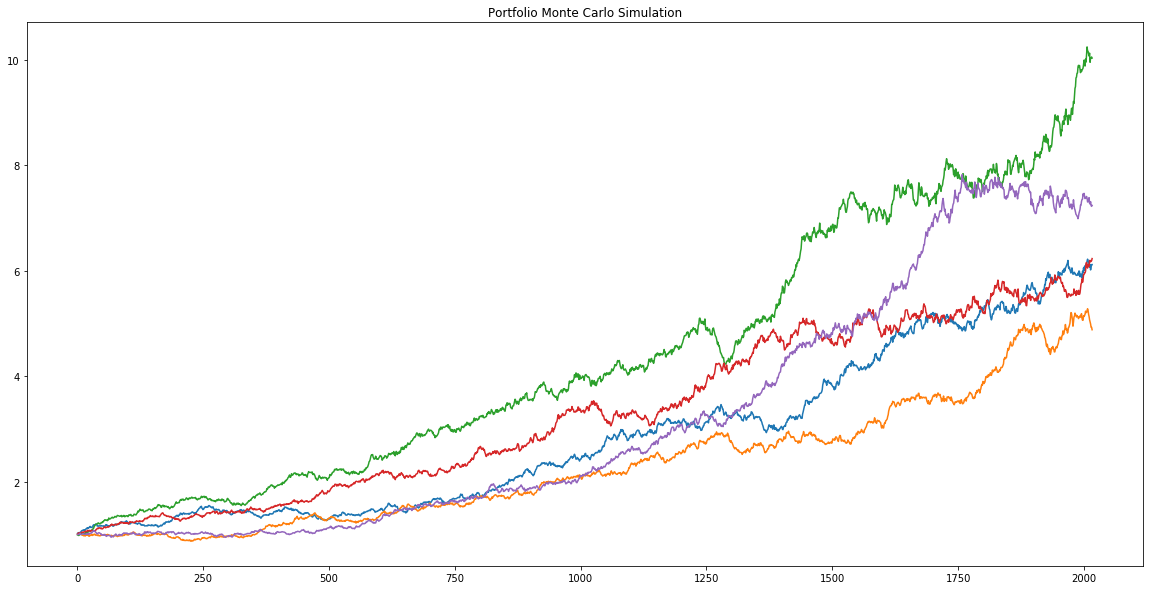

In [178]:
pf_montecarlo_returns.plot(title="Portfolio Monte Carlo Simulation",legend=None, figsize=(20,10))

TypeError: unsupported operand type(s) for +: 'AxesSubplot' and 'AxesSubplot'

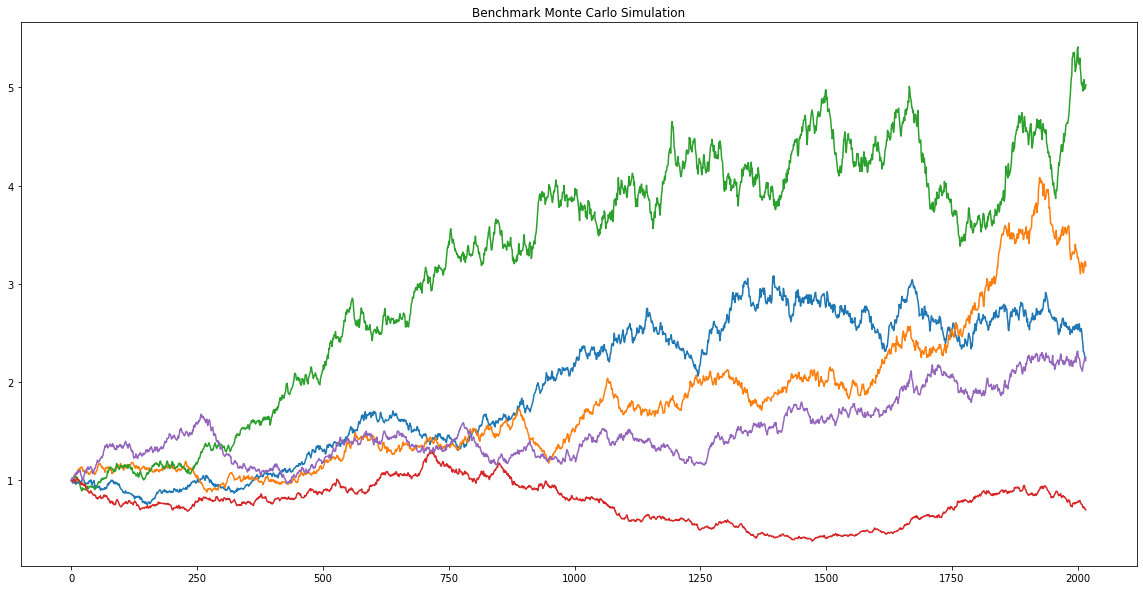

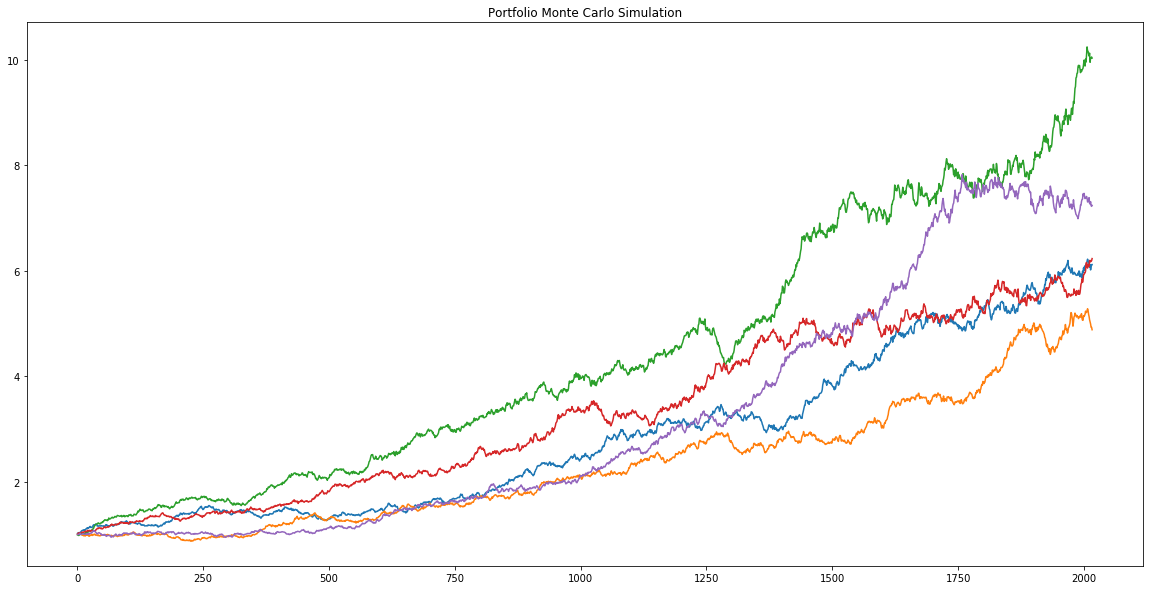

In [179]:
bm_montecarlo_returns.plot(title="Benchmark Monte Carlo Simulation",legend=None, figsize=(20,10))+pf_montecarlo_returns.plot(title="Portfolio Monte Carlo Simulation",legend=None, figsize=(20,10))